## XGBoost Classifier for the cancer diagnosis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install shap

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
import shap

In [6]:
import xgboost as xgb

In [7]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [8]:
project_path = "/content/drive/MyDrive/Colab Notebooks/cancer_diagnosis/"
data_path = project_path + "data/"

In [9]:
data_df = pd.read_csv(data_path + "data.csv")
data_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [11]:
columns_to_drop = ["id", "Unnamed: 32"]
data_df = data_df.drop(columns=columns_to_drop, axis = 1)

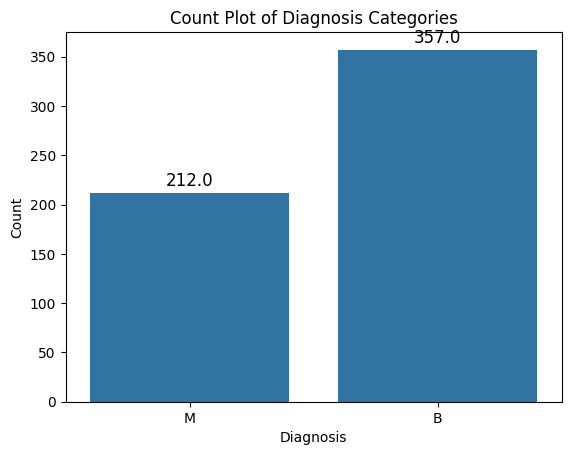

In [12]:
ax = sns.countplot(x="diagnosis", data=data_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Count Plot of Diagnosis Categories')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [13]:
y = data_df["diagnosis"].values
labelencoder = LabelEncoder()
labelencoder = labelencoder.fit(y)
Y = labelencoder.transform(y)
print(np.unique(Y))

[0 1]


In [14]:
labelencoder.inverse_transform(np.array([0, 1]))

array(['B', 'M'], dtype=object)

In [15]:
X = data_df.drop(columns = ["diagnosis"], axis = 1)
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Feature Scaling

In [16]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

(569, 30)

### Train Test Split

In [17]:
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


In [18]:
X_train, X_rem, y_train, y_rem = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, random_state = 42)
print("Shape of training data is  : ", X_train.shape, y_train.shape)
print("Shape of validation data is : ", X_val.shape, y_val.shape)
print("Shape of test data is : ", X_test.shape, y_test.shape)

Shape of training data is  :  (455, 30) (455,)
Shape of validation data is :  (57, 30) (57,)
Shape of test data is :  (57, 30) (57,)


### XGBoost Clasisifer

In [19]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators' : [10, 100, 200]
        }

# No. of folds for the datasets
folds = 3

param_comb = 3

# default parameter initialization
# might need changes in random state
xgb_model = xgb.XGBClassifier(learning_rate = 0.01, objective = "binary:logistic", random_state = 42)

# initializing stratified K Fold method
# skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 42)

# initializing the random search CV
# random_search = RandomizedSearchCV(xgb_model, param_distributions = params, n_iter = param_comb, scoring = "roc_auc", n_jobs = -1, cv = skf.split(X_train, y_train), verbose = 3, random_state = 42)
random_search = RandomizedSearchCV(xgb_model, param_distributions = params, n_iter = param_comb, scoring = "roc_auc", n_jobs = -1, cv = folds, verbose = 3, random_state = 42)

In [20]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [10, 100, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [21]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 All results:
{'mean_fit_time': array([0.15583189, 0.2406466 , 0.21726576]), 'std_fit_time': array([0.08609387, 0.05449732, 0.07557676]), 'mean_score_time': array([0.05046622, 0.03493237, 0.02900195]), 'std_score_time': array([0.02179066, 0.00876431, 0.01057182]), 'param_subsample': masked_array(data=[0.8, 1.0, 1.0],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[10, 100, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[10, 10, 10],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[5, 4, 5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[2, 0.5, 2],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_colsample_

In [22]:
display(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.155832,0.086094,0.050466,0.021791,0.8,10,10,5,2,1.0,"{'subsample': 0.8, 'n_estimators': 10, 'min_ch...",0.986049,0.969067,0.956203,0.970440,0.012223,3
1,0.240647,0.054497,0.034932,0.008764,1.0,100,10,4,0.5,1.0,"{'subsample': 1.0, 'n_estimators': 100, 'min_c...",0.993304,0.970914,0.981579,0.981932,0.009144,1
2,0.217266,0.075577,0.029002,0.010572,1.0,100,10,5,2,1.0,"{'subsample': 1.0, 'n_estimators': 100, 'min_c...",0.991908,0.970268,0.981391,0.981189,0.008836,2


In [23]:
best_xgb_model = random_search.best_estimator_

In [24]:
xgb_train_predictions = best_xgb_model.predict(X_train)
xgb_val_predictions = best_xgb_model.predict(X_val)
xgb_test_predictions = best_xgb_model.predict(X_test)

### Probability Prediction

In [25]:
xgb_train_probabilities = best_xgb_model.predict_proba(X_train)
xgb_val_probabilities = best_xgb_model.predict_proba(X_val)
xgb_test_probabilities = best_xgb_model.predict_proba(X_test)

print(xgb_train_probabilities.shape, xgb_val_probabilities.shape, xgb_test_probabilities.shape)

(455, 2) (57, 2) (57, 2)


In [26]:
def get_prediction_probability_class(train_prob, val_prob, test_prob, class_type = "class 0"):
  train_df = pd.DataFrame(train_prob, columns = ["class 0", "class 1"])
  val_df = pd.DataFrame(val_prob, columns = ["class 0", "class 1"])
  test_df = pd.DataFrame(test_prob, columns = ["class 0", "class 1"])

  sns.kdeplot(train_df[class_type], fill = True, color="red", label = "train class 0")
  sns.kdeplot(val_df[class_type], fill = True, color="blue", label = "val class 0")
  sns.kdeplot(test_df[class_type], fill = True, color="green", label = "test class 0")

  plt.title(f"{class_type} Density plot of predicted probabilities")
  plt.xlabel("Predicited Probability")
  plt.ylabel("Density")
  plt.legend()
  plt.show()
  print()

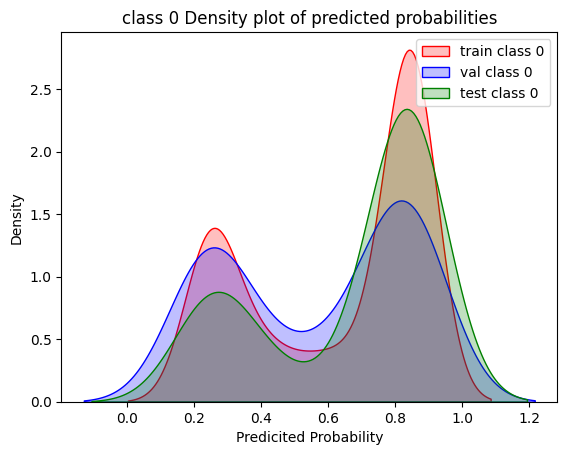

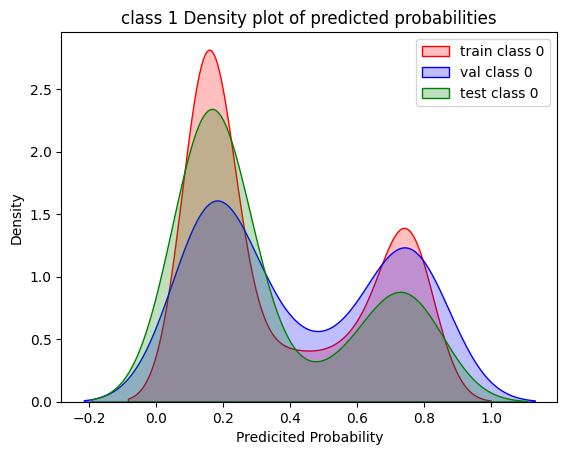

In [27]:
get_prediction_probability_class(xgb_train_probabilities, xgb_val_probabilities, xgb_test_probabilities, class_type = "class 0")
get_prediction_probability_class(xgb_train_probabilities, xgb_val_probabilities, xgb_test_probabilities, class_type = "class 1")

In [28]:
def get_prediction_probability_kde(probabilities, split = ""):
  probabilities_df = pd.DataFrame(probabilities, columns = ["class 0", "class 1"])
  sns.kdeplot(probabilities_df["class 0"], fill = True, color="blue", label = "class 0")
  sns.kdeplot(probabilities_df["class 1"], fill = True, color="red", label = "class 1")

  plt.title(f"{split} Density plot of predicted probabilities")
  plt.xlabel("Predicited Probability")
  plt.ylabel("Density")

  plt.legend()
  plt.show()
  print()

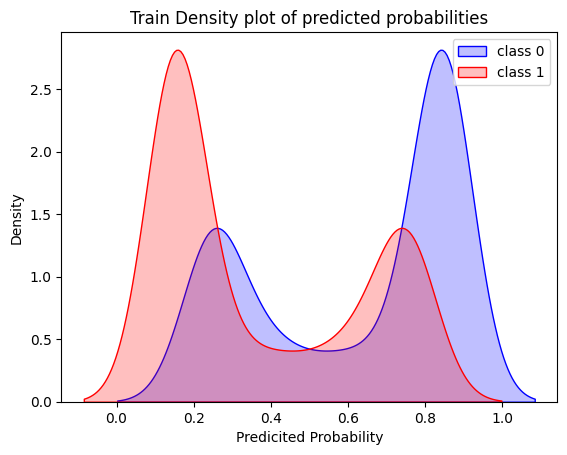

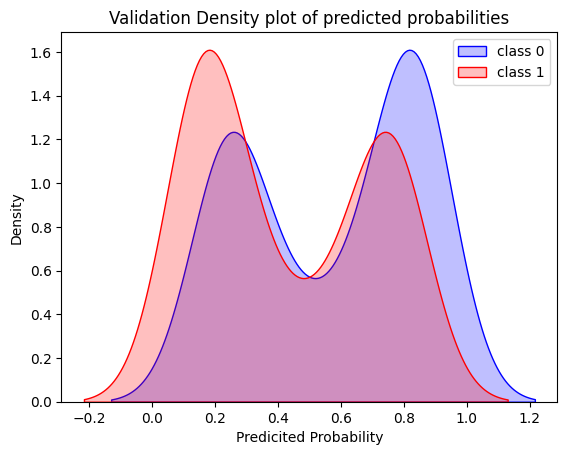

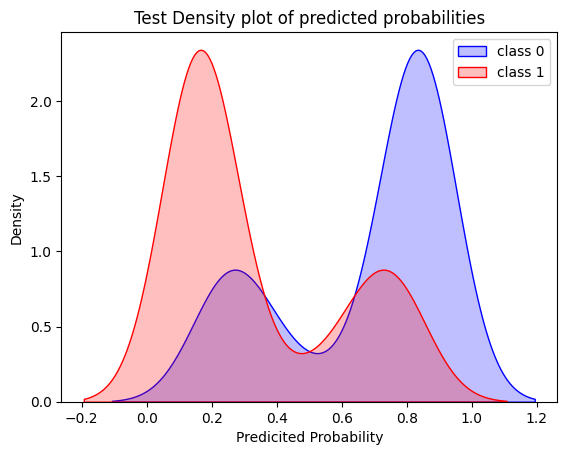

In [29]:
get_prediction_probability_kde(xgb_train_probabilities, split = "Train")
get_prediction_probability_kde(xgb_val_probabilities, split = "Validation")
get_prediction_probability_kde(xgb_test_probabilities, split = "Test")

### Evaluation

In [30]:
def get_classification_report(y_true, y_pred, title = "classification report"):
  print(title)
  xgb_model_report = classification_report(y_true, y_pred)
  print(xgb_model_report)

# def get_confusion_heatmap(y_true, y_pred, title = "confusion matrix"):
#   xgb_cm = confusion_matrix(y_true, y_pred)
#   sns.heatmap(xgb_cm, annot = True)
#   plt.title(title)
#   plt.show()
#   print()

def get_confusion_heatmap(y_true, y_pred, title = "confusion matrix"):
  print(np.unique(y_pred), np.unique(y_true))
  xgb_cm = confusion_matrix(y_true, y_pred)
  ax = sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=["Normal", "Anomaly"],
                 yticklabels=["Normal", "Anomaly"])

  plt.title(title)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()
  print()

In [31]:
get_classification_report(y_train, xgb_train_predictions, title = "train classification report")
get_classification_report(y_val, xgb_val_predictions, title = "val classification report")
get_classification_report(y_test, xgb_test_predictions, title = "test classification report")


train classification report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       286
           1       0.97      0.90      0.93       169

    accuracy                           0.95       455
   macro avg       0.96      0.94      0.95       455
weighted avg       0.95      0.95      0.95       455

val classification report
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        30
           1       0.96      0.85      0.90        27

    accuracy                           0.91        57
   macro avg       0.92      0.91      0.91        57
weighted avg       0.92      0.91      0.91        57

test classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        41
           1       0.94      0.94      0.94        16

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96    

[0 1] [0 1]


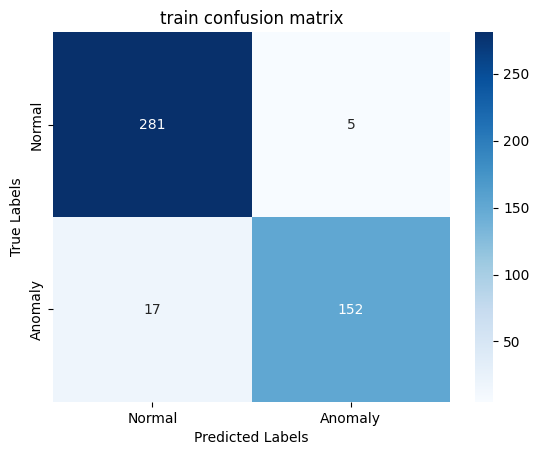


[0 1] [0 1]


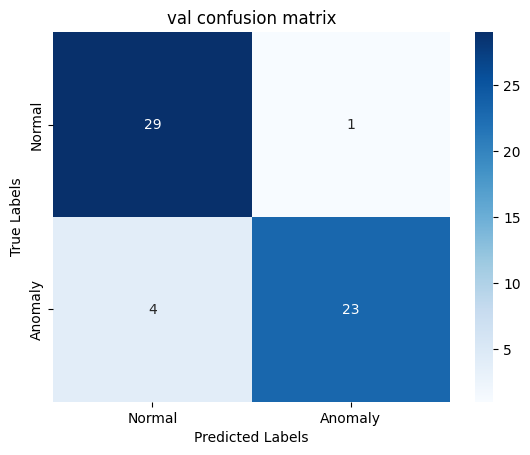


[0 1] [0 1]


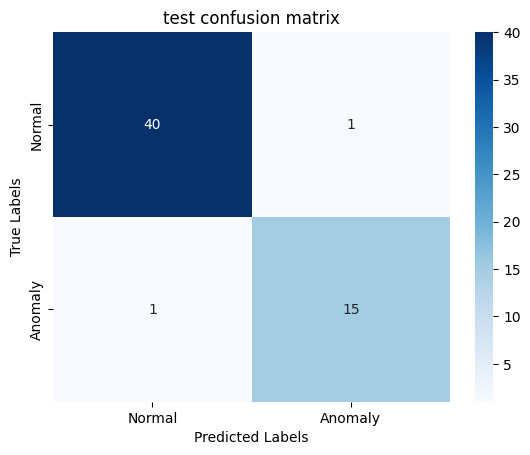

In [32]:
get_confusion_heatmap(y_train, xgb_train_predictions, title = "train confusion matrix")
get_confusion_heatmap(y_val, xgb_val_predictions, title = "val confusion matrix")
get_confusion_heatmap(y_test, xgb_test_predictions, title = "test confusion matrix")

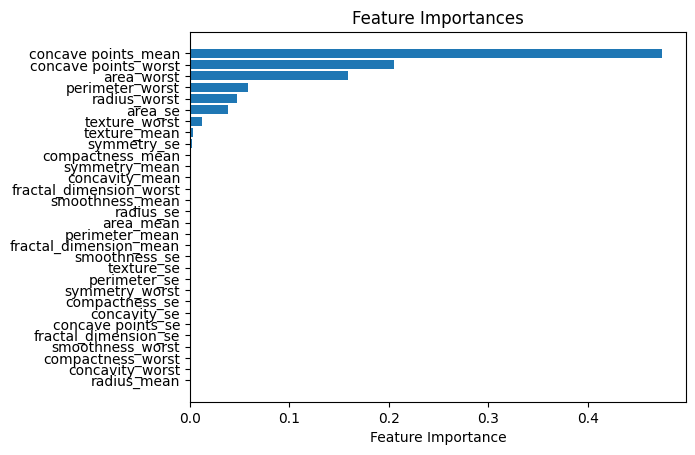

In [33]:
importances = best_xgb_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

## Shap Explainer

In [34]:
best_xgb_model.predict(X_test)

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0])

In [35]:
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

In [36]:
print(shap_values.shape, type(shap_values), X_test.shape, type(X_test))

(57, 30) <class 'numpy.ndarray'> (57, 30) <class 'pandas.core.frame.DataFrame'>


**It is model agnostic and uses the shapley values from game theory to estimate how does each feature contribute to the prediction**


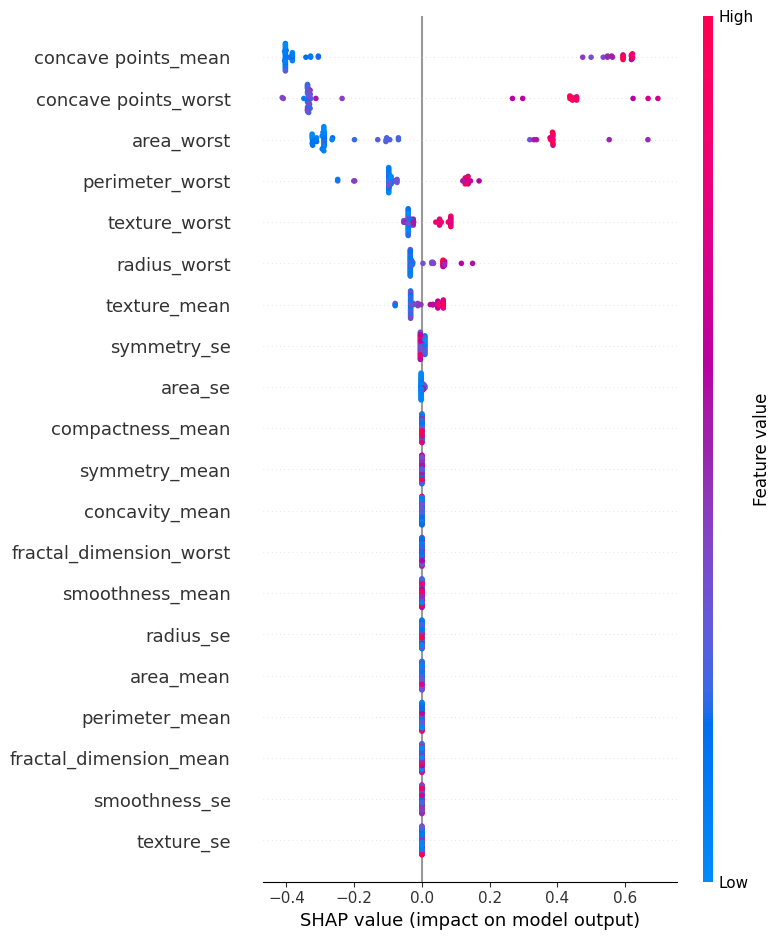

In [37]:
# visualize the feature importance
shap.summary_plot(shap_values, X_test, show=False, plot_type="dot", class_names=["Malignant", "Benign"])

In [38]:
X_test_np = X_test.to_numpy()

In [39]:
index = 6
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[index], X_test_np[index], feature_names=X_test.columns)

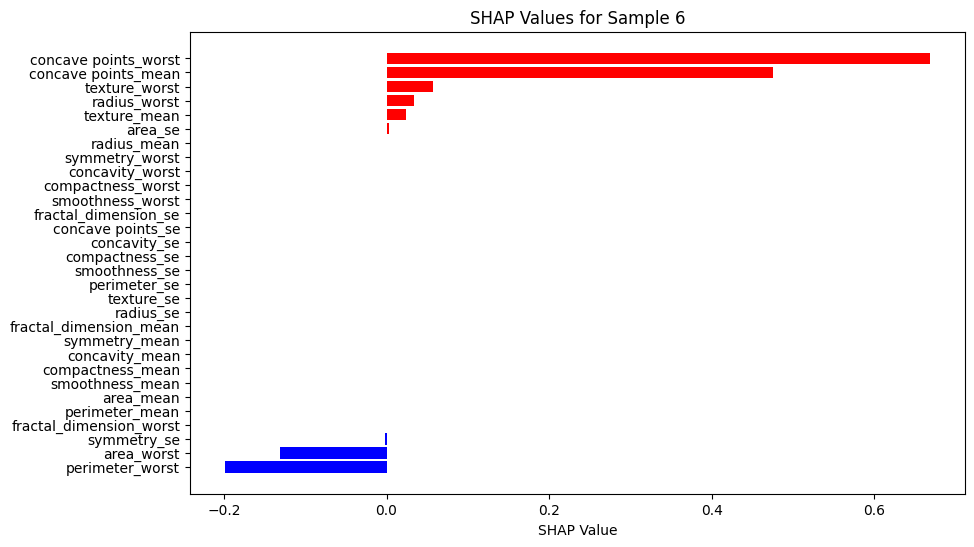

In [40]:
index = 6
feature_names = X_test.columns

shap_df = pd.DataFrame({
    "feature" : feature_names,
    "SHAP value" : shap_values[index]
})
shap_df = shap_df.sort_values(by="SHAP value", ascending = False)


colors = ['red' if value > 0 else 'blue' for value in shap_df['SHAP value']]


plt.figure(figsize=(10, 6))
bars = plt.barh(shap_df['feature'], shap_df['SHAP value'], color=colors)
plt.xlabel('SHAP Value')
plt.title(f'SHAP Values for Sample {index}')
plt.gca().invert_yaxis()
plt.show()

In [41]:
explainer_2 = shap.Explainer(best_xgb_model)
shap_values_2 = explainer_2(X_test)

In [51]:
X_test.iloc[6]

,196
radius_mean,0.321312
texture_mean,0.425431
perimeter_mean,0.323682
area_mean,0.188929
smoothness_mean,0.608197
compactness_mean,0.329182
concavity_mean,0.324508
concave points_mean,0.324354
symmetry_mean,0.390909
fractal_dimension_mean,0.396167


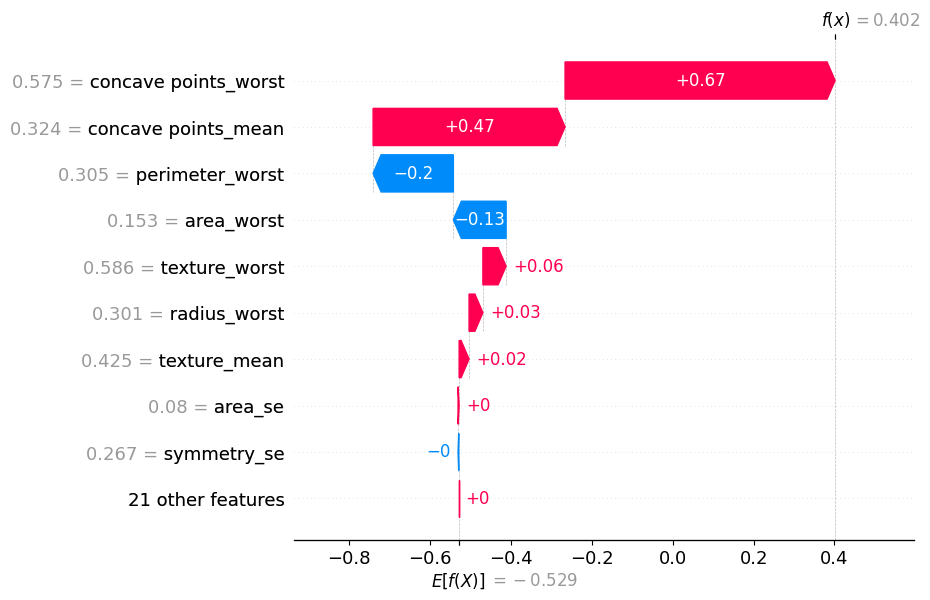

In [43]:
shap.plots.waterfall(shap_values_2[6])

In [44]:
shap_values[6]

array([ 0.        ,  0.02456343,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.47482687,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00267638,  0.        ,
        0.        ,  0.        ,  0.        , -0.00166253,  0.        ,
        0.03420317,  0.05740019, -0.19854592, -0.13045539,  0.        ,
        0.        ,  0.        ,  0.6679921 ,  0.        ,  0.        ],
      dtype=float32)

In [45]:
# sum of all shap values + expected value of prediction
sum(shap_values[6]) + (-0.529)

0.40199832313600925

In [46]:
# f(X)
f_x = 0.402
print("Probability for the positive class")
1 / (1 + np.exp(-f_x))

Probability for the positive class


0.5991680866194572

### Inference

In [47]:
# original prediction for this data is malignant
new_data = X_test.iloc[6]
new_data = new_data.to_frame().T.copy()

In [48]:
new_data

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
196,0.321312,0.425431,0.323682,0.188929,0.608197,0.329182,0.324508,0.324354,0.390909,0.396167,...,0.300961,0.586087,0.304746,0.152797,0.677079,0.276421,0.304233,0.574914,0.29864,0.251148


In [49]:
def predict_pipeline(new_data, scaler, labelencoder, scale_transform = False):
  if scale_transform:
    new_data = scaler.transform(new_data)

  pred = best_xgb_model.predict(new_data)

  margins = best_xgb_model.predict(new_data, output_margin=True)
  print("margins : ", margins)

  probabilities = best_xgb_model.predict_proba(new_data)
  print("probabilities : ", probabilities)
  print(labelencoder.inverse_transform(pred))

In [50]:
predict_pipeline(new_data, scaler, labelencoder)

margins :  [0.40152866]
probabilities :  [[0.40094513 0.5990549 ]]
['M']
